<a href="https://colab.research.google.com/github/sangar-si/LSTM-exploratory-amazon-dataset/blob/main/Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%pip install huggingface
%pip install datasets
%pip install --upgrade gensim --user

In [7]:
# sudo apt-get install git-lfs
# git lfs install
# git clone https://huggingface.co/fse/word2vec-google-news-300

In [50]:
import glob
import nltk
import gensim
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from sklearn.model_selection import train_test_split 
from keras import Sequential
import datasets
import os
from threading import Thread
import pickle
import matplotlib.pyplot as plt
import sklearn

In [5]:
#Downloading NLTK packages
try:
	nltk.download('stopwords')
	nltk.download('punkt')
	nltk.download('wordnet')
	nltk.download('averaged_perceptron_tagger')
	nltk.download('brown')
	nltk.download('universal_tagset')
except:
	print("Unable to download some nltk packages. Please ensure you have connectivity to internet")
	print("Required packages include stopwords, punkt, wordnet, brown and universal_tagset")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [6]:
ds = datasets.load_dataset('amazon_polarity')

Reusing dataset amazon_polarity (/root/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/56923eeb72030cb6c4ea30c8a4e1162c26b25973475ac1f44340f0ec0f2936f4)


  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
ds_train = ds['train']
df_train_orig = pd.DataFrame()
for field in ds_train.features:
  df_train_orig[field] = ds_train[field]

In [9]:
v_size = 20 # Size of the word embedding
max_len = 150 # Max length of sentences
preprocess_result = {}
lem = WordNetLemmatizer()
frac = 0.1 # Fraction of data to consider. Set 1 to consider the entire data.

stop_words = stopwords.words('english')
custom_stopwords = ['i','br','u','ive','im']
for w in custom_stopwords:
  stop_words.append(w)
for i in range(len(stop_words)):
  stop_words[i] = stop_words[i].replace("'","")

In [36]:
def combine_fields(f1:str, f2:str, df):
  f1_ = list(df[f1])
  f2_ = list(df[f2])
  return [i +" "+ j for i, j in zip(f1_, f2_)]

def preprocess_worker(start, stop, idx):
  raw = list(df_train['data'])
  raw = raw[start:stop]
  preprocess_result[idx] = [[lem.lemmatize(w).lower() for w in prelim_preprocess_compact(line, stop_words) if w.lower() not in stop_words] for line in raw]
  return None

def preprocess_df_threads(df, thread_count = 10):
  l = len(df)
  samples_per_thread = l//thread_count
  start = 0
  workers = []
  idx = 0
  stop = 0
  while(start<l):
    stop = min(stop+samples_per_thread,l) 
    t = Thread(target = preprocess_worker, args = (start,stop,idx))
    t.start()
    workers.append(t)
    start = stop
    idx+=1
  for worker in workers:
    worker.join()
  result = []
  for idx, line in preprocess_result.items():
    result += line
  return result

def prelim_preprocess(line, lem, stop_words):
  line = line.replace("'","").replace("’","")
  line = re.sub("[^A-Za-z']+",' ',line)
  token = word_tokenize(line) #Tokenize  
  return [lem.lemmatize(w).lower() for w in token if w.lower() not in stop_words]

def prelim_preprocess_compact(line, stop_words):
  line = line.replace("'","").replace("’","")
  line = re.sub("[^A-Za-z']+",' ',line)
  return word_tokenize(line) #Tokenize  

def preprocess_df(df, stop_words):
  raw = df['data']
  lem = WordNetLemmatizer()
  return [[lem.lemmatize(w).lower() for w in prelim_preprocess_compact(line, stop_words) if w.lower() not in stop_words] for line in raw]


def preprocess(line, stop_words):
# In preprocessing, we perform the removal of quotes, and are removing non alphabets using regular expression
# We are also tokenizing the words and are changing it to lowercase. We are also removing stop words
  lem = WordNetLemmatizer()
  line = line.replace("'","")
  line = line.replace("’","")
  line = re.sub("[^A-Za-z']+",' ',line) #Removing non-alphabets
  token = word_tokenize(line) #Tokenize
  clean = [lem.lemmatize(w).lower() for w in token if w.lower() not in stop_words]
  return clean


def preprocess_lstm(line, stop_words):
# In preprocessing, we perform the removal of quotes, and are removing non alphabets using regular expression
# We are also tokenizing the words and are changing it to lowercase. We are also removing stop words
  lem = WordNetLemmatizer()
  line = line.replace("'","")
  line = line.replace("’","")
  line = re.sub("[^A-Za-z']+",' ',line) #Removing non-alphabets
  token = word_tokenize(line) #Tokenize
  clean = [lem.lemmatize(w).lower() for w in token if w.lower() not in stop_words]
  return clean

def get_accuracy(pred,true):
# Returns the accuracy as a float value between 0 and 1.
# Accuracy is calculated as correct/total
  pred = np.array(pred)
  true = np.array(true)
  correct = np.sum((pred==true).astype(int))
  return correct/len(pred) 

def vector_embedding(sentence,w2v,max_len,vec_dim):
# This function returns the word embedding. We set a maximum length and returns only upto that length.
# Any sequence lesser than the defined length will be padded with 0.
  sentence_vec = [np.zeros(vec_dim)]*max_len
  for i in range(len(sentence)):
    idx = len(sentence)-1-i
    word = sentence[idx]
    try:
      vec = w2v.wv[word]
      sentence_vec.insert(0, vec)
    except:
      continue
  return sentence_vec[:max_len],None


def build_model(train_x, train_y, max_len = max_len, v_size = v_size, epochs_count = 40):
    model = Sequential()
    # Add 3 layers of LSTM
    # First Layer
    model.add(LSTM(units = 36, return_sequences = True, input_shape = (max_len, v_size)))
    model.add(Dropout(0.1))

    # Second Layer
    model.add(LSTM(units = 36, return_sequences = True))
    model.add(Dropout(0.1))

    # Third Layer
    model.add(LSTM(units = 36, return_sequences = True))
    model.add(Dropout(0.1))

    # Fourth Layer
    model.add(LSTM(units = 36, return_sequences = False))
    model.add(Dropout(0.1))

    # Dense layer
    model.add(Dense(units = 16, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))

    print(model.summary())
    
    # Compiling the LSTM
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    loss = keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(optimizer = opt, loss = loss, metrics = ['accuracy'])

    # Fitting the LSTM to the Training set
    history = model.fit(train_x, train_y, epochs = epochs_count, batch_size = 500)

    return model, history

In [11]:
df_train = df_train_orig.copy()
df_train['data'] = combine_fields('title', 'content', df_train_orig)
df_train = df_train.drop(columns = ['content', 'title'])
df_train = df_train.sample(frac=frac).reset_index()

In [12]:
preprocess_result = {}
# data_cleaned = preprocess_df_threads(df_train, 30)
data_cleaned = preprocess_df(df_train, stop_words)
df_train['data_cleaned'] = data_cleaned

In [15]:
# We define a word2vec model and we train it.
try:
  # w2v_model = Word2Vec.load(os.path.join(os.getcwd(),"models","w2v_model.model"))
  w2v_model = Word2Vec.load("/content/drive/MyDrive/models/w2v_model.model")
  print("Model loaded successfully")
except:
  print("Training word2vec model...")
  sentence_list = [sent for sent in df_train['data_cleaned']]
  w2v_model = gensim.models.Word2Vec(sentence_list,seed=0,min_count=1,size=v_size)
  %mkdir models
  w2v_model.save(os.path.join(os.getcwd(),"models","w2v_model.model"))
vec_dim = len(w2v_model.wv['movie'])

Model loaded successfully


In [16]:
print("Preparing training data...")
train_sentences = df_train['data_cleaned']
train_label = df_train['label'].values
train_label = train_label.reshape(len(train_label),1)
train_x = []
train_x = [vector_embedding(sent, w2v_model, max_len = max_len, vec_dim = vec_dim)[0] for sent in df_train['data_cleaned']]


Preparing testing data...


In [17]:
train_x = np.array(train_x)

In [ ]:
model, history = build_model(train_x,train_label, epochs_count=40)
# Make sure you print the final training accuracy
# Getting the final train accuracy
predicted = model.predict(train_x)
pred = np.round(predicted).astype(int).reshape(-1).tolist()
acc = get_accuracy(pred,df_train['label'])
# Printing the final train accuracy
print("Train accuracy is ",acc)

In [22]:
model = keras.models.load_model(os.path.join(os.getcwd(),"models","lstm_model.keras"))

# Model Testing

In [26]:
ds_test = ds['test']
df_test = pd.DataFrame()
for field in ds_test.features:
  df_test[field] = ds_test[field]

In [27]:
df_test['data'] = combine_fields('title', 'content', df_test)
df_test = pd.concat([df_test[df_test['label']==1].sample(frac=0.4), df_test[df_test['label']==0].sample(frac=0.4)])
df_test = df_test.sample(frac=1).reset_index()
df_test = df_test.drop(columns = ['content', 'title'])

In [28]:
preprocess_result = {}
# df_test['data_cleaned'] = preprocess_df_threads(df_test, 30)
df_test['data_cleaned'] = preprocess_df(df_test, stop_words)

In [29]:
print("Preparing testing data...")
test_sentences = df_test['data_cleaned']
test_label = df_test['label'].values
test_label = test_label.reshape(len(test_label),1)
test_x = [vector_embedding(sent, w2v_model, max_len = max_len, vec_dim = vec_dim)[0] for sent in df_test['data_cleaned']]

Preparing testing data...


In [30]:
test_x = np.array(test_x)

In [31]:
predicted = model.predict(test_x)
pred = np.round(predicted).astype(int).reshape(-1).tolist()
acc = get_accuracy(pred,df_test['label'])
print("Test accuracy is ", acc)

Test accuracy is  0.86579375


In [47]:
def get_split(df,neg = 0.5):
  neg = min(neg,0.5)
  df_pos = df[df['label']==1]
  df_neg = df[df['label']==0].sample(frac=neg/0.5)
  df2 = pd.concat([df_pos,df_neg],axis=0,verify_integrity=True)
  return df2.sample(frac=1).reset_index()

def f1_score(pred,target):
  

In [53]:
negative_ratio = 0.1
real_world_skewed_data = df_test.copy()
real_world_skewed_data = get_split(real_world_skewed_data,negative_ratio)

preprocess_result = {}
real_world_skewed_data['data_cleaned'] = preprocess_df(real_world_skewed_data, stop_words)

print("Preparing testing data...")
test_sentences = real_world_skewed_data['data_cleaned']
test_label = real_world_skewed_data['label'].values
test_label = test_label.reshape(len(test_label),1)
test_x = [vector_embedding(sent, w2v_model, max_len = max_len, vec_dim = vec_dim)[0] for sent in real_world_skewed_data['data_cleaned']]
test_x = np.array(test_x)

Preparing testing data...


In [54]:
predicted = model.predict(test_x)
pred = np.round(predicted).astype(int).reshape(-1).tolist()
acc = get_accuracy(pred,real_world_skewed_data['label'])
print("Real world simulated test accuracy is ", acc)

Real world simulated test accuracy is  0.8712708333333333


In [55]:
f1 = sklearn.metrics.f1_score(real_world_skewed_data['label'], pred)
print("F1 score is ",f1)

F1 score is  0.91890118255437


In [58]:
len(real_world_skewed_data[real_world_skewed_data['label']==0])/len(real_world_skewed_data)

0.16666666666666666

In [ ]:
# 3. Save your model
%mkdir models
model.save(os.path.join(os.getcwd(),"models","lstm_model.keras"))
w2v_model.save(os.path.join(os.getcwd(),"models","w2v_model.model"))

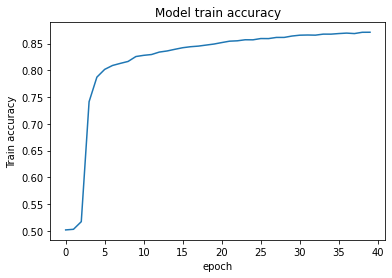

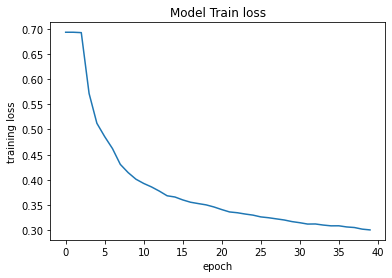

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model train accuracy')
plt.ylabel('Train accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['loss'])
plt.title('Model Train loss')
plt.ylabel('training loss')
plt.xlabel('epoch')
plt.show()